In [2]:
import copy
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import interpolate_replace_nans
from astropy.convolution import convolve
from photutils.segmentation import detect_sources
from scipy import ndimage

# Configuration needs to come first
import os

os.environ["MKL_NUM_THREADS"] = "8"  # Enable multi-threading
os.environ["NSCLEAN_USE_CUPY"] = "NO"  # Use GPU. If you change this, you will
#   need to restart python. In practice,
#   I have found that most of the time
#   the GPU is no faster than using CPUs.

# Import the appropriate numerical libraries
if os.getenv("NSCLEAN_USE_CUPY") == "YES":
    import cupy as cp
    import numpy as np
else:
    import numpy as cp
    import numpy as np

# Other imports
from time import perf_counter as t  # Used for benchmarking
import matplotlib.pyplot as plt

from util import *

# It will be handy to have a stack
time_stack = []  # Used for benchmarking

# NSClean specific
import nsclean as nc

# Files

In [2]:
# Make a list of input files
files = sorted(
    glob.glob(stage1_processed_directory + "*nrs1_rate.fits", recursive=True)
)

In [3]:
files

['/Users/ajshajib/Research/1131_JWST/data/stage1_processed/jw01794001001_02101_00001_nrs1_rate.fits',
 '/Users/ajshajib/Research/1131_JWST/data/stage1_processed/jw01794001001_02101_00002_nrs1_rate.fits',
 '/Users/ajshajib/Research/1131_JWST/data/stage1_processed/jw01794001001_02101_00003_nrs1_rate.fits',
 '/Users/ajshajib/Research/1131_JWST/data/stage1_processed/jw01794001001_02101_00004_nrs1_rate.fits',
 '/Users/ajshajib/Research/1131_JWST/data/stage1_processed/jw01794001001_04101_00001_nrs1_rate.fits',
 '/Users/ajshajib/Research/1131_JWST/data/stage1_processed/jw01794001001_04101_00002_nrs1_rate.fits',
 '/Users/ajshajib/Research/1131_JWST/data/stage1_processed/jw01794001001_04101_00003_nrs1_rate.fits',
 '/Users/ajshajib/Research/1131_JWST/data/stage1_processed/jw01794001001_04101_00004_nrs1_rate.fits',
 '/Users/ajshajib/Research/1131_JWST/data/stage1_processed/jw01794001001_06101_00001_nrs1_rate.fits',
 '/Users/ajshajib/Research/1131_JWST/data/stage1_processed/jw01794001001_06101_000

In [4]:
header = fits.getheader(files[0])

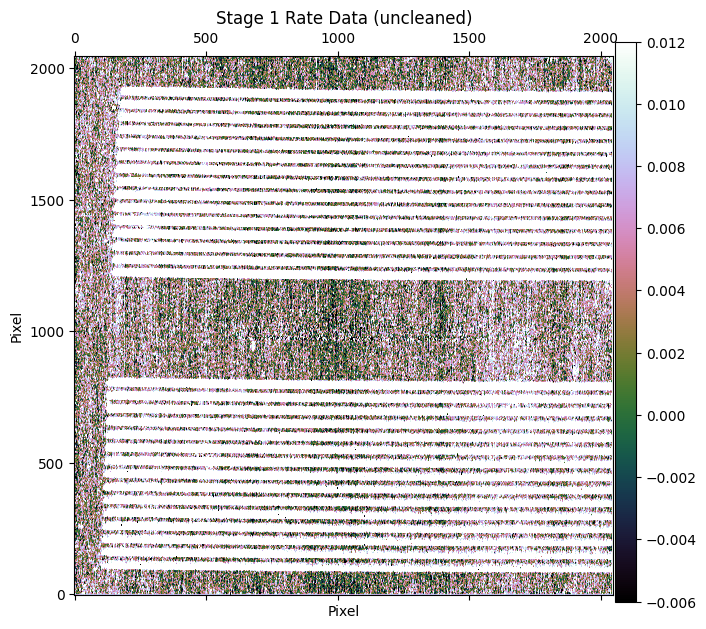

In [5]:
def plot_image(
    arr,
    size=7,
    limit=True,
    smooth=True,
    log=False,
    title="",
    vmax=0.012,
    vmin=-0.006,
    cmap="cubehelix",
):
    """
    Plot a smoothed version of the array

    :param arr: array to plot
    :param size: size of the figure
    :param limit: limit the colorbar
    :param smooth: smooth the array
    :param log: log the array
    :param title: title of the plot
    :param vmax: max value of the colorbar
    :param vmin: min value of the colorbar
    :param cmap: colormap
    :return: None
    """
    temp = copy.deepcopy(arr)

    temp[np.isnan(temp)] = np.nanmedian(temp)

    if smooth:
        gauss = Gaussian1DKernel(stddev=2)
        # temp = gaussian_filter(temp, sigma=1)
        # temp = gaussian_filter1d(temp, sigma=1, axis=0)
        for i in range(temp.shape[1]):
            temp[:, i] = convolve(temp[:, i], gauss)

    fig = plt.figure(figsize=(size, size))
    ax = fig.add_subplot(111)
    ax.matshow(
        np.log10(temp) if log else temp,
        cmap=cmap,
        vmax=vmax if limit else None,
        vmin=vmin if limit else None,
        origin="lower",
    )
    ax.set_title(title)
    ax.set_xlabel("Pixel")
    ax.set_ylabel("Pixel")
    # colorbar
    cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
    # cax.set_title()
    fig.colorbar(ax.images[0], cax=cax, orientation="vertical")
    plt.show()


stage1_rate = fits.getdata(files[0])
plot_image(stage1_rate, title="Stage 1 Rate Data (uncleaned)")

# Make mask

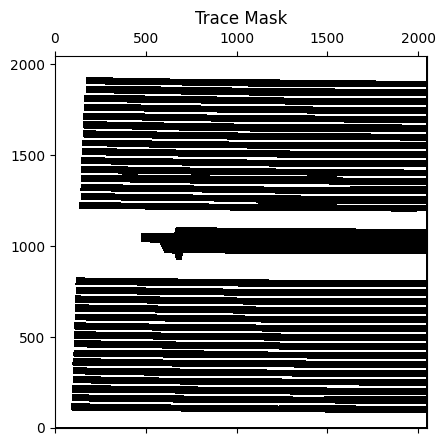

In [6]:
trace_mask = fits.getdata("nrs1_trace_mask.fits", ignore_missing_simple=True)

plt.matshow(trace_mask, origin="lower", cmap="Greys_r")
plt.title("Trace Mask")
plt.show()

2023-12-23 11:47:48,017 - stpipe - WARNING - /var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_7624/3275998866.py:40: RuntimeWarning: invalid value encountered in log10
  np.log10(temp) if log else temp,



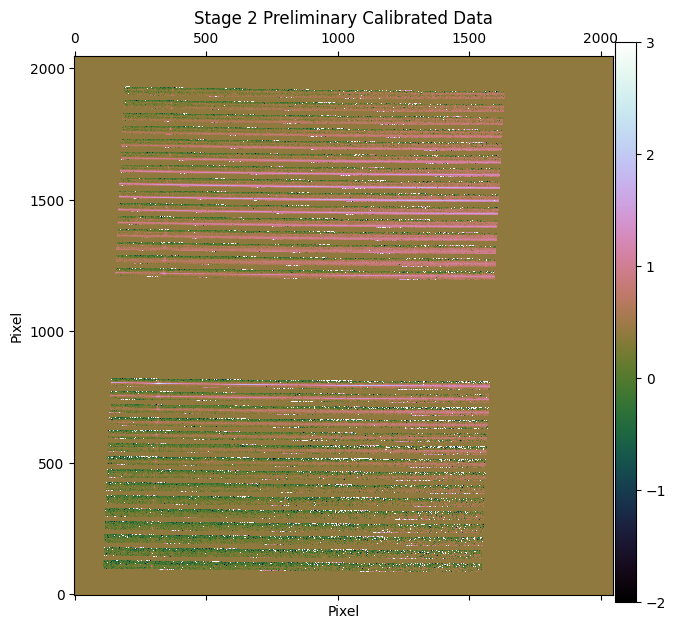

In [7]:
stage2_cal = fits.getdata("../data/stage2/jw01794001001_02101_00001_nrs1_cal.fits")

plot_image(
    stage2_cal,
    smooth=False,
    limit=True,
    log=True,
    vmax=3,
    vmin=-2,
    title="Stage 2 Preliminary Calibrated Data",
)

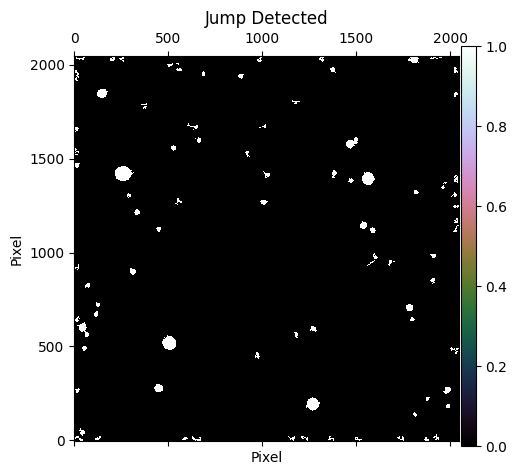

Number of pixels with jump detected: 65600


In [96]:
def get_pixel_map_with_jumps(file, size=350):
    """Get pixel map with jump detected.
    
    :param file: rate file
    :param size: size of the region to be removed
    :return: pixel map with jump detected
    """
    dq_flag = fits.getdata(file, ext=3)
    jump = (dq_flag & 4) == 4
    
    jump = ndimage.binary_fill_holes(jump)
    
    # detect and remove regions smaller than size with astropy  
    jump = detect_sources(jump, 0.1, npixels=size).data
    jump[jump > 0] = 1

    return jump

jump_detected = get_pixel_map_with_jumps(files[0])
# plt.imshow(jump_detected, origin='lower', cmap=jump_detected.cmap,
#            interpolation='nearest')
# 
# plt.show()
# print(len(jump_detected.labels))

plot_image(
    jump_detected, 
    size=5, limit=False, smooth=False, log=False, 
    title="Jump Detected"
)
print(f"Number of pixels with jump detected: {np.sum(jump_detected)}")

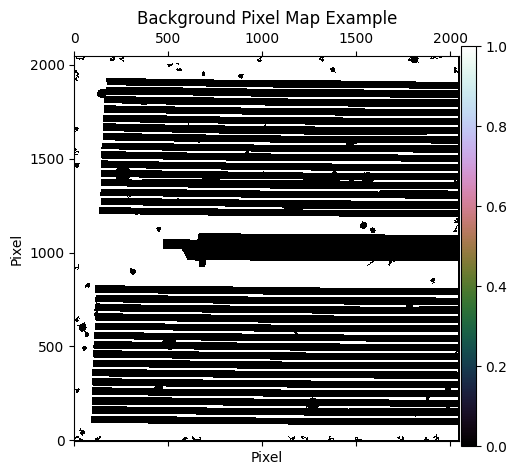

In [97]:
def get_background_pixel_map_with_jumps(pixel_map_with_jumps, dilate_size=0):
    """Get a map of pixels that are background pixels.

    :param pixel_map_with_jumps: pixels that have been flagged as having a jump
    :return: background pixel map
    """
    background_pixels_map = np.zeros_like(stage2_cal, dtype=np.bool_)
    background_pixels_map[np.isnan(stage2_cal)] = True

    # fixed slits area
    # background_pixels_map[910:1140, 400:] = False

    background_pixels_map = np.logical_and(background_pixels_map, trace_mask)
    background_pixels_map = np.logical_and(
        background_pixels_map, np.logical_not(pixel_map_with_jumps)
    )

    if dilate_size > 0:
        not_background = np.logical_not(background_pixels_map)
        not_background = ndimage.binary_dilation(
            not_background, structure=np.ones((dilate_size, dilate_size))
        )

        background_pixels_map = np.logical_not(not_background)

    return background_pixels_map


plot_image(
    get_background_pixel_map_with_jumps(jump_detected, dilate_size=0),
    title="Background Pixel Map Example",
    size=5,
    limit=False,
    smooth=False,
    log=False,
)

Pixels =0 are ignored. Pixels =1 are used for modeling the background. NSClean requires that the mask be passed as a boolean array.

# Process NRS1 Files

  0%|          | 0/18 [00:00<?, ?it/s]

Number of pixels with NaN values: 68837


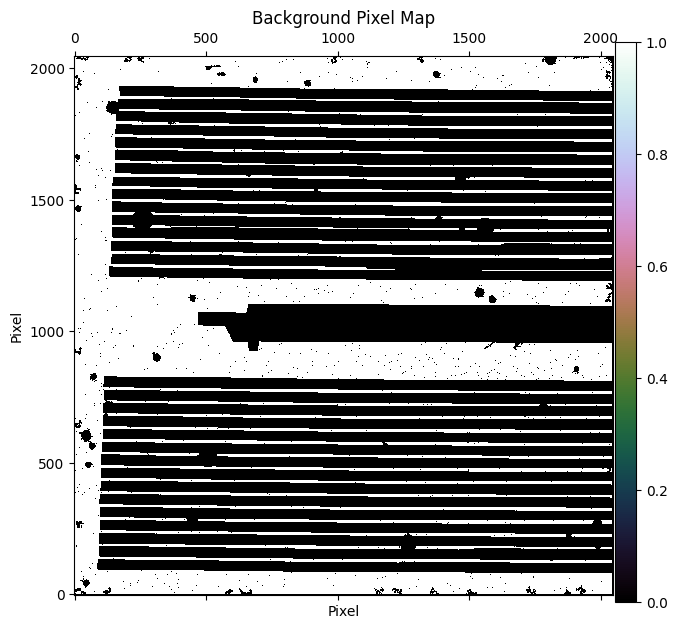

2023-12-23 13:00:46,531 - stpipe - WARNING - /Users/ajshajib/miniconda3/envs/jwst/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2023-12-23 13:00:46,531 - stpipe - WARNING - /Users/ajshajib/miniconda3/envs/jwst/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



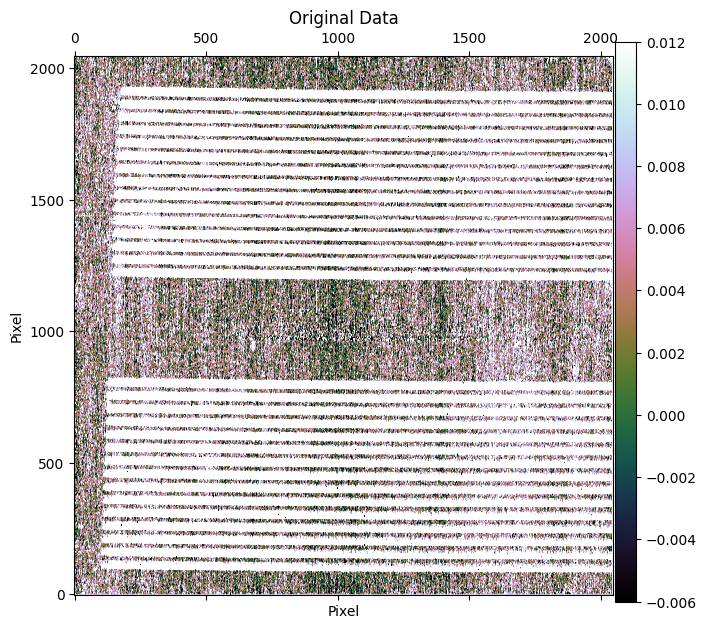

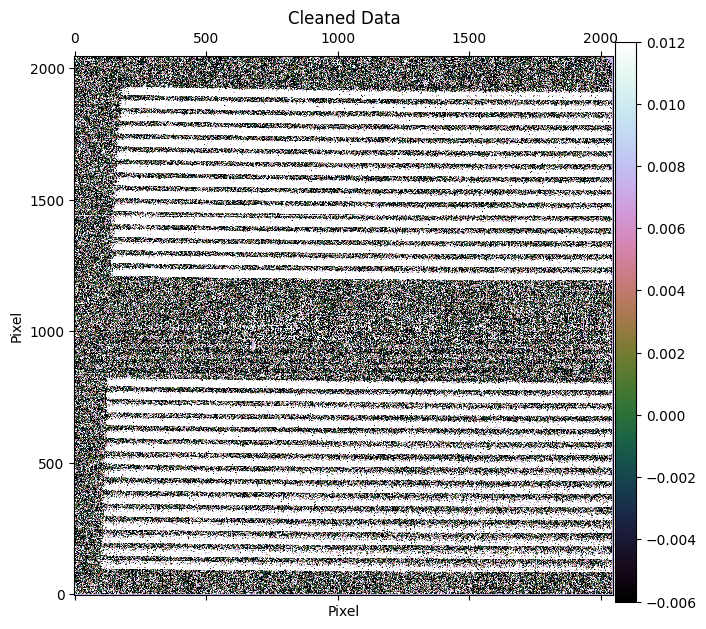

Execution time (s) =  16.422396500000104


In [98]:
time_stack.append(t())  # Put start time on stack

from tqdm.notebook import tnrange

for i in tnrange(len(files)):
    with fits.open(files[i]) as hdu:
        header_0 = hdu[0].header
        header_1 = hdu[1].header
        data = cp.array(hdu[1].data)

    if i == 0:
        print(f"Number of pixels with NaN values: {np.sum(np.isnan(data))}")

    # # find which row has all NaN in data
    # for j in range(data.shape[0]):
    #     if np.sum(np.isnan(data[j, :])) == data.shape[1]:
    #         print(f"Row {j} has all NaN values")
    #
    # break
    
    jump_detected = get_pixel_map_with_jumps(files[i])

    # jump_detected[jump_detected == True]  = False
    jump_detected[np.isnan(data)] = True
    jump_detected[np.isinf(data)] = True

    background_pixel_map = get_background_pixel_map_with_jumps(
        jump_detected, dilate_size=0
    )

    background_pixel_map[:, :5] = False
    background_pixel_map = cp.array(background_pixel_map, dtype=cp.bool_)
    cleaner = nc.NSClean("NRS2", background_pixel_map)

    if i == 0:
        plot_image(
            background_pixel_map,
            size=7,
            limit=False,
            smooth=False,
            log=False,
            title="Background Pixel Map",
        )

    # Clean it
    clean_data = cleaner.clean(np.copy(data), buff=False)

    if i == 0:
        plot_image(data, title="Original Data")
        plot_image(clean_data, title="Cleaned Data", smooth=False)

    # Save it to FITS
    header_0["comment"] = "Processed by NSClean Rev. " + nc.__version__

    if os.getenv("NSCLEAN_USE_CUPY") == "YES":
        hdu = fits.HDUList(
            [
                fits.PrimaryHDU(header=header_0),
                fits.ImageHDU(cp.asnumpy(clean_data), header=header_1, name="SCI"),
            ]
        )
    else:
        hdu = fits.HDUList(
            [
                fits.PrimaryHDU(header=header_0),
                fits.ImageHDU(clean_data, header=header_1, name="SCI"),
            ]
        )

    hdu.writeto(
        stage1_nsclean_directory
        + nc.chsuf(os.path.basename(files[i]), ".cln_mask.fits"),
        overwrite=True,
    )
    hdu.close()

    break

print("Execution time (s) = ", t() - time_stack.pop())